In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import os
import pandas as pd
import mlrun

from mlrun.datastore import DataItem
from mlrun.artifacts import get_model, update_model
from mlrun.mlutils import eval_model_v2
from cloudpickle import load
from urllib.request import urlopen

def test_classifier(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "",
    model_evaluator = None,
    default_model: str = "model.pkl",
    predictions_column: str = 'yscore',
    model_update = True
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:            the function context
    :param models_path:        artifact models representing a file or a folder
    :param test_set:           test features and labels
    :param label_column:       column name for ground truth labels
    :param score_method:       for multiclass classification
    :param plots_dest:         dir for test plots
    :param model_evaluator:    NOT IMPLEMENTED: specific method to generate eval, passed in as string
                               or available in this folder
    :param predictions_column: column name for the predictions column on the resulted artifact
    :param model_update:       (True) update model, when running as stand alone no need in update
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except Exception as a:
        raise Exception("model location likely specified")
    
    extra_data = eval_model_v2(context, xtest, ytest.values, model_obj)
    if model_obj and model_update == True:
        update_model(models_path, extra_data=extra_data, 
                     metrics=context.results, key_prefix='validation-')
    
    # get y_hat:
    y_hat = model_obj.predict(xtest)
    # give the prediction columns titles/headers
    if y_hat.ndim == 1 or y_hat.shape[1] == 1:
        score_names = [predictions_column]
    else:
        score_names = [f"{predictions_column}_" + str(x) for x in range(y_hat.shape[1])]

    # log the test set and its predictions (should also bind model and metadata)
    df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
    context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [4]:
# nuclio: end-code

### MLconfig

In [5]:
artifact_path = mlrun.set_environment(api_path = 'http://mlrun-api:8080',
                                      artifact_path = os.path.abspath('./'))

> 2020-10-18 17:19:48,320 [warning] warning!, server (0.5.1) and client (0.5.2) ver dont match


### Save

In [6]:
# create job function object from notebook code
fn = mlrun.code_to_function("test_classifier", 
                            handler="test_classifier",
                            description="test a classifier using held-out or new data",
                            categories=["ml", "test"],
                            labels = {"author": "yjb", "framework": "sklearn"},
                            code_output='.')
fn.export()

> 2020-10-18 17:20:01,350 [info] function spec saved to path: function.yaml


## Tests

In [7]:
fn.apply(mlrun.platforms.auto_mount())

### Run Locally

In [8]:
DATA_PATH  = 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'
MODEL_PATH = 'https://s3.wasabisys.com/iguazio/models/iris/model.pkl'

> 2020-10-18 17:20:01,386 [warning] warning!, server (0.5.1) and client (0.5.2) ver dont match
> 2020-10-18 17:20:01,386 [info] starting run mlrun-0653a6-test_classifier uid=335c028c99884c8683a1197a14cb0aa5  -> http://mlrun-api:8080
> 2020-10-18 17:20:01,420 [warning] warning!, server (0.5.1) and client (0.5.2) ver dont match


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...14cb0aa5,0,Oct 18 17:20:01,completed,mlrun-0653a6-test_classifier,v3io_user=idanbkind=handlerowner=idanbhost=idan-jupyter-5f8568c8b5-cpvv6,test_setmodels_path,label_column=labelmodel_update=False,accuracy=0.9533333333333334test-error=0.04666666666666667auc-micro=0.9892444444444445auc-weighted=0.9939333333333333f1-score=0.9533286661999534precision_score=0.9534480458850206recall_score=0.9533333333333333,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 335c028c99884c8683a1197a14cb0aa5 --project default , !mlrun logs 335c028c99884c8683a1197a14cb0aa5 --project default
> 2020-10-18 17:20:05,627 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

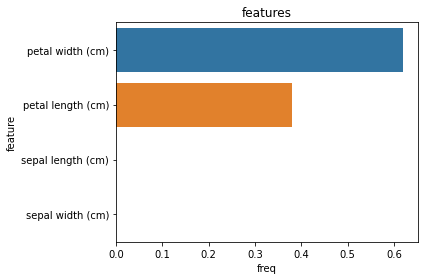

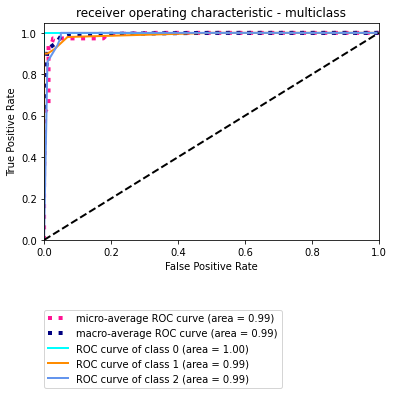

In [9]:
run = mlrun.run_local(mlrun.NewTask(params= {'label_column':'label',
                                             'model_update': False}), #Change to True when you have a old model metadata to update
                                    handler=test_classifier,
                                    inputs={"test_set": DATA_PATH,
                                            "models_path": MODEL_PATH})

### Run remotely

In [10]:
fn.run(mlrun.NewTask(params= {'label_column':'label',
                              'model_update': False}), #Change to True when you have a old model metadata to update
                      handler=test_classifier,
                      inputs={"test_set": DATA_PATH,
                              "models_path": MODEL_PATH})

> 2020-10-18 17:20:06,397 [warning] warning!, server (0.5.1) and client (0.5.2) ver dont match
> 2020-10-18 17:20:06,398 [info] starting run test-classifier-test_classifier uid=3411e5fabd3749fb8216fe227f0ba76c  -> http://mlrun-api:8080
> 2020-10-18 17:20:06,533 [info] Job is running in the background, pod: test-classifier-test-classifier-lz8k2
> 2020-10-18 17:20:15,767 [info] run executed, status=completed
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...7f0ba76c,0,Oct 18 17:20:12,completed,test-classifier-test_classifier,v3io_user=idanbkind=jobowner=idanbhost=test-classifier-test-classifier-lz8k2,test_setmodels_path,label_column=labelmodel_update=False,accuracy=0.9533333333333334test-error=0.04666666666666667auc-micro=0.9892444444444445auc-weighted=0.9939333333333333f1-score=0.9533286661999534precision_score=0.9534480458850206recall_score=0.9533333333333333,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 3411e5fabd3749fb8216fe227f0ba76c --project default , !mlrun logs 3411e5fabd3749fb8216fe227f0ba76c --project default
> 2020-10-18 17:20:25,739 [info] run executed, status=completed
